In [2]:


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from math import sqrt

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

import datetime
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional

from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot




# In[4]:


window = 1
lstm_units = 10
dropout = 0.01


df_14, df_15, df_16, df_17, df_18, df_19, df_20 = [pd.read_csv(fr"C:\Users\Khalid\Downloads\Taipei_{i}.csv") 
                                                   for i in range(14,21)]

# In[3]:


# In[13]:


def get_X_and_Y(table, station_name = 'Banqiao'):
    table = table[table.SiteEngName =='Banqiao']
    features=table[['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5','RAINFALL', 'RH']]
    print(f'The shape of the input table is {features.shape}')
    data = np.array(features.values.reshape((-1,10*1)))
    timestep=1
    x_build = []
    for i in range(data.shape[0] - timestep - timestep):
        x_build.append(data[i:i+timestep])
    train_x = np.array(x_build)
    print(f'The shape of the input train_x is {train_x.shape}')


    data = np.array(table['PM2.5'].values.reshape((-1, 1)))
    y_build = []
    for i in range(timestep, data.shape[0] - timestep):
        y_build.append(data[i:i+timestep])
    train_y = np.array(y_build)
    print(f'The shape of the input train_y is {train_y.shape}')
    print('-'*50)
    return (train_x, train_y)

train14_x, train14_y = get_X_and_Y(df_14, station_name = 'Banqiao')
train15_x, train15_y = get_X_and_Y(df_15, station_name = 'Banqiao')
train16_x, train16_y = get_X_and_Y(df_16, station_name = 'Banqiao')
train17_x, train17_y = get_X_and_Y(df_17, station_name = 'Banqiao')
train18_x, train18_y = get_X_and_Y(df_18, station_name = 'Banqiao')
train19_x, train19_y = get_X_and_Y(df_19, station_name = 'Banqiao')
train20_x, train20_y = get_X_and_Y(df_20, station_name = 'Banqiao')


# In[14]:


train_X=np.concatenate((train14_x,train15_x,train16_x,train17_x,train18_x,train19_x),axis=0)
print(train_X.shape)
train_y=np.concatenate((train14_y,train15_y,train16_y,train17_y,train18_y,train19_y),axis=0)
print(train_y.shape)
test_X=train20_x;test_y=train20_y
print(train20_x.shape,train20_y.shape)


# In[15]:


from sklearn.model_selection import train_test_split
# create dataset
X, y = test_X,test_y

# split into train test sets
valid_x,test_x,valid_y,test_y = train_test_split(X, y, test_size=0.5)
print(valid_x.shape, valid_y.shape,test_x.shape, test_y.shape)


# In[16]:


print(train_X.shape, train_y.shape, test_x.shape, test_y.shape) 


# In[10]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed

# Define ODE layer (custom layer with serialization support)
class ODEBlock(tf.keras.layers.Layer):
    def __init__(self, ode_func, *args, **kwargs):
        super(ODEBlock, self).__init__(*args, **kwargs)
        self.ode_func = ode_func

    def call(self, inputs, **kwargs):
        return self.ode_func(inputs)
    
    # Override get_config method to make the layer serializable
    def get_config(self):
        config = super(ODEBlock, self).get_config()
        config.update({
            'ode_func': self.ode_func  # Ensure ode_func is passed correctly
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Return an instance of the layer using config
        ode_func = config.pop('ode_func')
        return cls(ode_func=ode_func, **config)

# Example of an ODE function for simplicity
def ode_func(x):
    # Example ODE function: dx/dt = -alpha * x (exponential decay)
    alpha = 0.1
    return -alpha * x

# Building the ODE-LSTM model
def build_ode_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM Layer
    x = LSTM(64, return_sequences=True)(inputs)
    
    # ODE Layer (acts on the output of LSTM)
    x = ODEBlock(ode_func)(x)
    
    # Output layer (TimeDistributed for predicting sequence data)
    outputs = TimeDistributed(Dense(1))(x)
    
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape based on your data
input_shape = (1, 10)  # 1 time step, 10 features

# Build and compile the model
model = build_ode_lstm_model(input_shape)

# Summary of the model
model.summary()

# Assuming you have your data loaded into the following variables
# X_train, y_train, X_test, y_test

# Fit the model
# model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


# In[9]:


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "Banqiao1.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback   = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

#Train the model with the new callback
history = model.fit((train_X) ,
                    (train_y), 
                    validation_data=((valid_x),
                                    (valid_y)),
                    epochs =50, batch_size=19, verbose = 2, shuffle = True,
                    callbacks=[cp_callback])


# In[ ]:


model.load_weights(checkpoint_path)


# In[ ]:


scores = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', scores)
predict_ary = model.predict([test_x.astype("float")], batch_size = 190)
print (predict_ary.shape)
print (test_y.shape)
#print (X_valid.shape)
rmse_score20 = np.sqrt(np.mean(np.square(predict_ary - test_y.astype("float"))))
mae_score = np.mean(np.abs(predict_ary - test_y.astype("float")))
#mape_score = mean_absolute_percentage_error(y_valid_c.astype("float"),predict_ary)
#mae2 = mean_absolute_error(predict_ary, validation_Y[:-3])
print('this is rmse ',rmse_score20)
#print('this is mape ',mape_score)
print('this is mae ',mae_score)







The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of

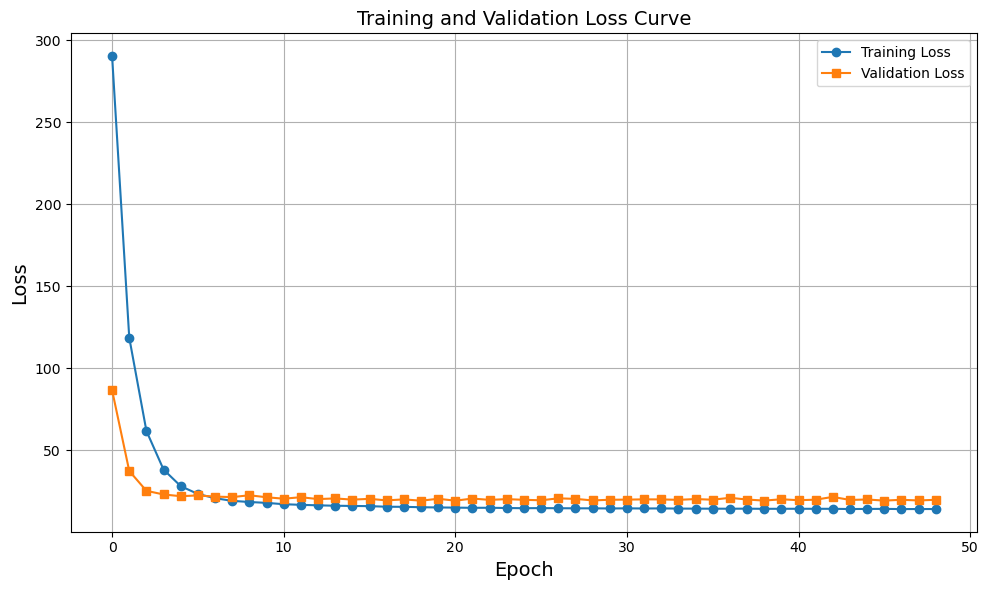

In [3]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training and Validation Loss Curve')
plt.title('Training and Validation Loss Curve',size=14)
plt.xlabel('Epoch',size=14)
plt.ylabel('Loss',size=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from math import sqrt

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

import datetime
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional

from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot




# In[4]:


window = 1
lstm_units = 10
dropout = 0.01


# In[5]:



df_14, df_15, df_16, df_17, df_18, df_19, df_20 = [pd.read_csv(fr"C:\Users\Khalid\Downloads\Taipei_{i}.csv") 
                                                   for i in range(14,21)]
# In[13]:


def get_X_and_Y(table, station_name = 'Guting'):
    table = table[table.SiteEngName =='Guting']
    features=table[['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5','RAINFALL', 'RH']]
    print(f'The shape of the input table is {features.shape}')
    data = np.array(features.values.reshape((-1,10*1)))
    timestep=1
    x_build = []
    for i in range(data.shape[0] - timestep - timestep):
        x_build.append(data[i:i+timestep])
    train_x = np.array(x_build)
    print(f'The shape of the input train_x is {train_x.shape}')


    data = np.array(table['PM2.5'].values.reshape((-1, 1)))
    y_build = []
    for i in range(timestep, data.shape[0] - timestep):
        y_build.append(data[i:i+timestep])
    train_y = np.array(y_build)
    print(f'The shape of the input train_y is {train_y.shape}')
    print('-'*50)
    return (train_x, train_y)

train14_x, train14_y = get_X_and_Y(df_14, station_name = 'Guting')
train15_x, train15_y = get_X_and_Y(df_15, station_name = 'Guting')
train16_x, train16_y = get_X_and_Y(df_16, station_name = 'Guting')
train17_x, train17_y = get_X_and_Y(df_17, station_name = 'Guting')
train18_x, train18_y = get_X_and_Y(df_18, station_name = 'Guting')
train19_x, train19_y = get_X_and_Y(df_19, station_name = 'Guting')
train20_x, train20_y = get_X_and_Y(df_20, station_name = 'Guting')


# In[14]:


train_X=np.concatenate((train14_x,train15_x,train16_x,train17_x,train18_x,train19_x),axis=0)
print(train_X.shape)
train_y=np.concatenate((train14_y,train15_y,train16_y,train17_y,train18_y,train19_y),axis=0)
print(train_y.shape)
test_X=train20_x;test_y=train20_y
print(train20_x.shape,train20_y.shape)


# In[15]:


from sklearn.model_selection import train_test_split
# create dataset
X, y = test_X,test_y

# split into train test sets
valid_x,test_x,valid_y,test_y = train_test_split(X, y, test_size=0.5)
print(valid_x.shape, valid_y.shape,test_x.shape, test_y.shape)


# In[16]:


print(train_X.shape, train_y.shape, test_x.shape, test_y.shape) 


# In[10]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed

# Define ODE layer (custom layer with serialization support)
class ODEBlock(tf.keras.layers.Layer):
    def __init__(self, ode_func, *args, **kwargs):
        super(ODEBlock, self).__init__(*args, **kwargs)
        self.ode_func = ode_func

    def call(self, inputs, **kwargs):
        return self.ode_func(inputs)
    
    # Override get_config method to make the layer serializable
    def get_config(self):
        config = super(ODEBlock, self).get_config()
        config.update({
            'ode_func': self.ode_func  # Ensure ode_func is passed correctly
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Return an instance of the layer using config
        ode_func = config.pop('ode_func')
        return cls(ode_func=ode_func, **config)

# Example of an ODE function for simplicity
def ode_func(x):
    # Example ODE function: dx/dt = -alpha * x (exponential decay)
    alpha = 0.1
    return -alpha * x

# Building the ODE-LSTM model
def build_ode_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM Layer
    x = LSTM(64, return_sequences=True)(inputs)
    
    # ODE Layer (acts on the output of LSTM)
    x = ODEBlock(ode_func)(x)
    
    # Output layer (TimeDistributed for predicting sequence data)
    outputs = TimeDistributed(Dense(1))(x)
    
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape based on your data
input_shape = (1, 10)  # 1 time step, 10 features

# Build and compile the model
model = build_ode_lstm_model(input_shape)

# Summary of the model
model.summary()

# Assuming you have your data loaded into the following variables
# X_train, y_train, X_test, y_test

# Fit the model
# model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


# In[9]:


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "Guting1.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback   = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

#Train the model with the new callback
history = model.fit((train_X) ,
                    (train_y), 
                    validation_data=((valid_x),
                                    (valid_y)),
                    epochs =50, batch_size=19, verbose = 2, shuffle = True,
                    callbacks=[cp_callback])


# In[ ]:


model.load_weights(checkpoint_path)


# In[ ]:


scores = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', scores)
predict_ary = model.predict([test_x.astype("float")], batch_size = 190)
print (predict_ary.shape)
print (test_y.shape)
#print (X_valid.shape)
rmse_score20 = np.sqrt(np.mean(np.square(predict_ary - test_y.astype("float"))))
mae_score = np.mean(np.abs(predict_ary - test_y.astype("float")))
#mape_score = mean_absolute_percentage_error(y_valid_c.astype("float"),predict_ary)
#mae2 = mean_absolute_error(predict_ary, validation_Y[:-3])
print('this is rmse ',rmse_score20)
#print('this is mape ',mape_score)
print('this is mae ',mae_score)


# In[ ]:


The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8758, 1, 10)
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of

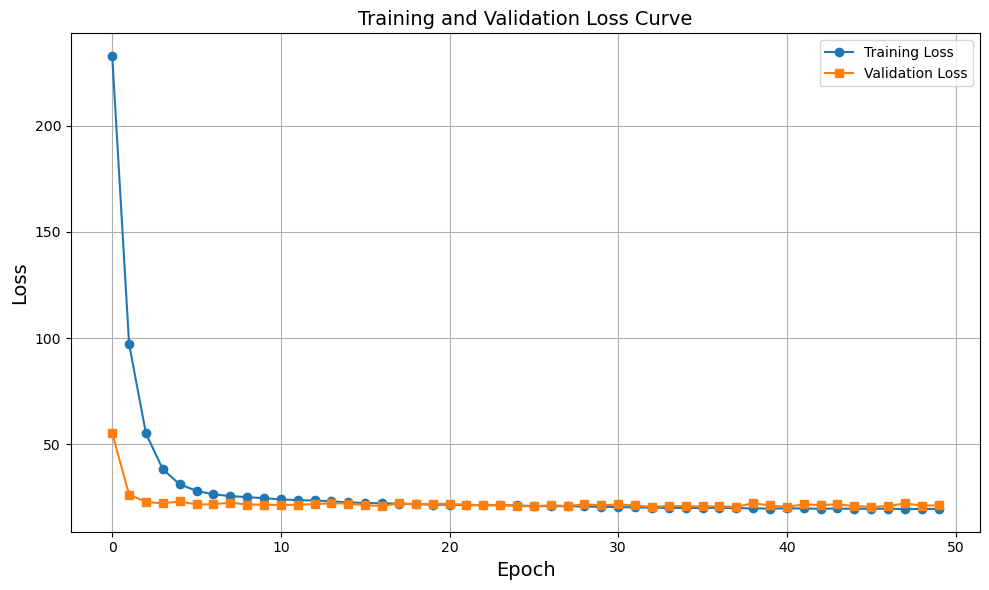

In [7]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training and Validation Loss Curve')
plt.title('Training and Validation Loss Curve',size=14)
plt.xlabel('Epoch',size=14)
plt.ylabel('Loss',size=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from math import sqrt

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

import datetime
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional

from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot




# In[4]:


window = 1
lstm_units = 10
dropout = 0.01


# In[5]:



df_14, df_15, df_16, df_17, df_18, df_19, df_20 = [pd.read_csv(fr"C:\Users\Khalid\Downloads\Taipei_{i}.csv") 
                                                   for i in range(14,21)]
# In[13]:


def get_X_and_Y(table, station_name = 'Guting'):
    table = table[table.SiteEngName =='Guting']
    features=table[['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5','RAINFALL', 'RH']]
    print(f'The shape of the input table is {features.shape}')
    data = np.array(features.values.reshape((-1,10*1)))
    timestep=16
    x_build = []
    for i in range(data.shape[0] - timestep - timestep):
        x_build.append(data[i:i+timestep])
    train_x = np.array(x_build)
    print(f'The shape of the input train_x is {train_x.shape}')


    data = np.array(table['PM2.5'].values.reshape((-1, 1)))
    y_build = []
    for i in range(timestep, data.shape[0] - timestep):
        y_build.append(data[i:i+timestep])
    train_y = np.array(y_build)
    print(f'The shape of the input train_y is {train_y.shape}')
    print('-'*50)
    return (train_x, train_y)

train14_x, train14_y = get_X_and_Y(df_14, station_name = 'Guting')
train15_x, train15_y = get_X_and_Y(df_15, station_name = 'Guting')
train16_x, train16_y = get_X_and_Y(df_16, station_name = 'Guting')
train17_x, train17_y = get_X_and_Y(df_17, station_name = 'Guting')
train18_x, train18_y = get_X_and_Y(df_18, station_name = 'Guting')
train19_x, train19_y = get_X_and_Y(df_19, station_name = 'Guting')
train20_x, train20_y = get_X_and_Y(df_20, station_name = 'Guting')


# In[14]:


train_X=np.concatenate((train14_x,train15_x,train16_x,train17_x,train18_x,train19_x),axis=0)
print(train_X.shape)
train_y=np.concatenate((train14_y,train15_y,train16_y,train17_y,train18_y,train19_y),axis=0)
print(train_y.shape)
test_X=train20_x;test_y=train20_y
print(train20_x.shape,train20_y.shape)


# In[15]:


from sklearn.model_selection import train_test_split
# create dataset
X, y = test_X,test_y

# split into train test sets
valid_x,test_x,valid_y,test_y = train_test_split(X, y, test_size=0.5)
print(valid_x.shape, valid_y.shape,test_x.shape, test_y.shape)


# In[16]:


print(train_X.shape, train_y.shape, test_x.shape, test_y.shape) 


# In[10]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed

# Define ODE layer (custom layer with serialization support)
class ODEBlock(tf.keras.layers.Layer):
    def __init__(self, ode_func, *args, **kwargs):
        super(ODEBlock, self).__init__(*args, **kwargs)
        self.ode_func = ode_func

    def call(self, inputs, **kwargs):
        return self.ode_func(inputs)
    
    # Override get_config method to make the layer serializable
    def get_config(self):
        config = super(ODEBlock, self).get_config()
        config.update({
            'ode_func': self.ode_func  # Ensure ode_func is passed correctly
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Return an instance of the layer using config
        ode_func = config.pop('ode_func')
        return cls(ode_func=ode_func, **config)

# Example of an ODE function for simplicity
def ode_func(x):
    # Example ODE function: dx/dt = -alpha * x (exponential decay)
    alpha = 0.1
    return -alpha * x

# Building the ODE-LSTM model
def build_ode_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM Layer
    x = LSTM(64, return_sequences=True)(inputs)
    
    # ODE Layer (acts on the output of LSTM)
    x = ODEBlock(ode_func)(x)
    
    # Output layer (TimeDistributed for predicting sequence data)
    outputs = TimeDistributed(Dense(1))(x)
    
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape based on your data
input_shape = (16, 10)  # 1 time step, 10 features

# Build and compile the model
model = build_ode_lstm_model(input_shape)

# Summary of the model
model.summary()

# Assuming you have your data loaded into the following variables
# X_train, y_train, X_test, y_test

# Fit the model
# model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


# In[9]:


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "Guting1164.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback   = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

#Train the model with the new callback
history = model.fit((train_X) ,
                    (train_y), 
                    validation_data=((valid_x),
                                    (valid_y)),
                    epochs =50, batch_size=19, verbose = 2, shuffle = True,
                    callbacks=[cp_callback])


# In[ ]:


model.load_weights(checkpoint_path)


# In[ ]:


scores = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', scores)
predict_ary = model.predict([test_x.astype("float")], batch_size = 190)
print (predict_ary.shape)
print (test_y.shape)
#print (X_valid.shape)
rmse_score20 = np.sqrt(np.mean(np.square(predict_ary - test_y.astype("float"))))
mae_score = np.mean(np.abs(predict_ary - test_y.astype("float")))
#mape_score = mean_absolute_percentage_error(y_valid_c.astype("float"),predict_ary)
#mae2 = mean_absolute_error(predict_ary, validation_Y[:-3])
print('this is rmse ',rmse_score20)
#print('this is mape ',mape_score)
print('this is mae ',mae_score)

# In[ ]:


The shape of the input table is (8760, 10)
The shape of the input train_x is (8728, 16, 10)
The shape of the input train_y is (8728, 16, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8728, 16, 10)
The shape of the input train_y is (8728, 16, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8728, 16, 10)
The shape of the input train_y is (8728, 16, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8728, 16, 10)
The shape of the input train_y is (8728, 16, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
The shape of the input train_x is (8728, 16, 10)
The shape of the input train_y is (8728, 16, 1)
--------------------------------------------------
The shape of the input table is (8760, 10)
Th

In [2]:
print('this is rmse ',rmse_score20)
#print('this is mape ',mape_score)
print('this is mae ',mae_score)

this is rmse  7.599196005969081
this is mae  5.927497731579428


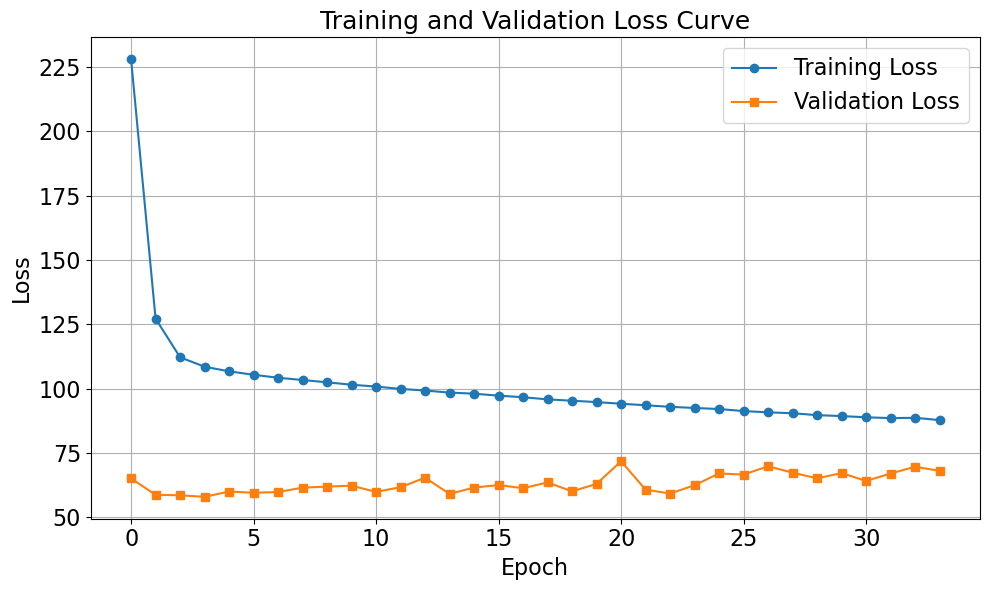

In [3]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')

plt.title('Training and Validation Loss Curve', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)

# Enlarged legend
plt.legend(fontsize=16)

# Enlarged tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)
plt.tight_layout()
plt.show()